   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 98.7/98.7 MB 8.2 MB/s eta 0:00:00
Available columns: Index(['Business_ID', 'Annual_Revenue (₹)', 'Loan_Amount (₹)',
       'GST_Compliance (%)', 'Past_Defaults', 'Bank_Transactions',
       'Market_Trend', 'Credit_Score', 'Cash_Flow_Stability',
       'Supplier_Payment_Timeliness (%)', 'Ecommerce_Sales_Volume (%)',
       'Tax_Filing_Compliance (%)', 'Social_Media_Engagement_Score',
       'Loan_Default_Probability (%)', 'Macroeconomic_Sensitivity'],
      dtype='object')
0:	learn: 0.0531747	test: 0.0316599	best: 0.0316599 (0)	total: 49.4ms	remaining: 1m 38s
200:	learn: 0.9999983	test: 0.7115843	best: 0.7115843 (200)	total: 363ms	remaining: 3.25s
400:	learn: 1.0000000	test: 0.7117144	best: 0.7117154 (352)	total: 692ms	remaining: 2.76s
Stopped by overfitting detector  (200 iterations wait)

bestTest = 0.7117153748
bestIteration = 352

Shrink model to first 353 iterations.
Mean Absolute Error (MAE): 49.22331195281958
R² Score: 0.711715374803902

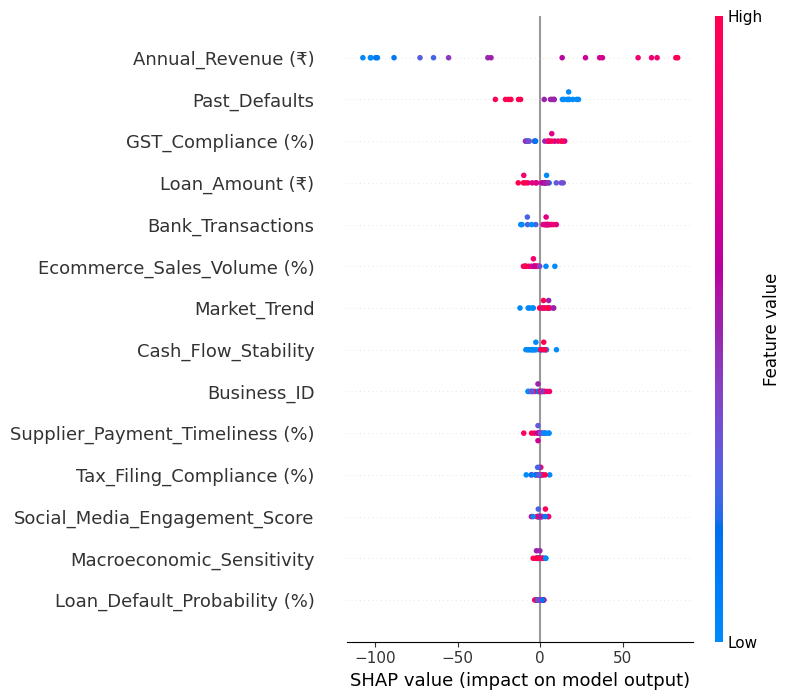

In [ ]:
!pip install catboost
!pip install shap

import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler, LabelEncoder
from catboost import CatBoostRegressor, Pool
from sklearn.metrics import mean_absolute_error, r2_score
import shap

# Load dataset
data_path = "/content/enhanced_credit_data.csv"
df = pd.read_csv(data_path)

# Check available columns
print("Available columns:", df.columns)

# Handle missing values
df.fillna(df.median(numeric_only=True), inplace=True)  # Fill numeric NaNs with median
df.fillna(df.mode().iloc[0], inplace=True)  # Fill categorical NaNs with mode

# Encode categorical features
categorical_cols = df.select_dtypes(exclude=[np.number]).columns.tolist()
for col in categorical_cols:
    le = LabelEncoder()
    df[col] = le.fit_transform(df[col])

# Feature Engineering (Only add if columns exist)
if 'cash_flow' in df.columns and 'liabilities' in df.columns:
    df['cash_to_liabilities_ratio'] = df['cash_flow'] / (df['liabilities'] + 1e-5)

if 'annual_revenue' in df.columns:
    df['revenue_growth'] = df['annual_revenue'].pct_change().fillna(0)

# Selecting Features
target = "Credit_Score"
features = [col for col in df.columns if col not in [target, 'risk_category']]

# Scaling
scaler = MinMaxScaler()
df[features] = scaler.fit_transform(df[features])

# Splitting dataset
X = df[features]
y = df[target]
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Optimized Hyperparameters
params = {
    'iterations': 2000,
    'learning_rate': 0.05,
    'depth': 8,
    'l2_leaf_reg': 3,
    'loss_function': 'MAE',
    'eval_metric': 'R2',
    'verbose': 200
}

# Train the model
catboost_model = CatBoostRegressor(**params)
catboost_model.fit(X_train, y_train, eval_set=(X_test, y_test), early_stopping_rounds=200)

# Predictions
y_pred = catboost_model.predict(X_test)

# Model Evaluation
mae = mean_absolute_error(y_test, y_pred)
r2 = r2_score(y_test, y_pred)

# Convert R² to percentage
r2_percentage = r2 * 100

# Calculate MAE percentage
mae_percentage = (mae / y_test.mean()) * 100

# Compute Accuracy (100% - MAE %)
accuracy = 100 - mae_percentage

# Print Results
print(f"Mean Absolute Error (MAE): {mae}")
print(f"R² Score: {r2} ({r2_percentage:.2f}%)")
print(f"Mean Absolute Error Percentage: {mae_percentage:.2f}%")
print(f"Model Accuracy (based on MAE%): {accuracy:.2f}%")


# Feature Importance using SHAP
explainer = shap.TreeExplainer(catboost_model)
shap_values = explainer.shap_values(X_test)
shap.summary_plot(shap_values, X_test)

In [ ]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler, LabelEncoder
from catboost import CatBoostRegressor
from sklearn.metrics import mean_absolute_error, r2_score

# Load dataset
file_path = "/content/enhanced_credit_data.csv"
df = pd.read_csv(file_path)

# Handle missing values
df.fillna(df.median(numeric_only=True), inplace=True)  # Fill numeric NaNs with median
df.fillna(df.mode().iloc[0], inplace=True)  # Fill categorical NaNs with mode

# Encode categorical features
categorical_cols = df.select_dtypes(exclude=[np.number]).columns.tolist()
for col in categorical_cols:
    le = LabelEncoder()
    df[col] = le.fit_transform(df[col])

# Feature Engineering (If applicable)
if 'cash_flow' in df.columns and 'liabilities' in df.columns:
    df['cash_to_liabilities_ratio'] = df['cash_flow'] / (df['liabilities'] + 1e-5)

if 'annual_revenue' in df.columns:
    df['revenue_growth'] = df['annual_revenue'].pct_change().fillna(0)

# Selecting Features
target = "Credit_Score"
features = [col for col in df.columns if col not in [target, 'risk_category']]

# Scaling
scaler = MinMaxScaler()
df[features] = scaler.fit_transform(df[features])

# Splitting dataset
X = df[features]
y = df[target]
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Optimized Hyperparameters
params = {
    'iterations': 2000,
    'learning_rate': 0.05,
    'depth': 8,
    'l2_leaf_reg': 3,
    'loss_function': 'MAE',
    'eval_metric': 'R2',
    'verbose': 200
}

# Train the model
catboost_model = CatBoostRegressor(**params)
catboost_model.fit(X_train, y_train, eval_set=(X_test, y_test), early_stopping_rounds=200, verbose=False)

# Predict final CIBIL score for the dataset
final_cibil_score = catboost_model.predict(X).mean()  # Averaging predictions for overall score

# Extracting additional financial metrics
cibil_scores = df["Credit_Score"].mean() if "Credit_Score" in df.columns else None
cash_to_liabilities_ratio = df["cash_to_liabilities_ratio"].mean() if "cash_to_liabilities_ratio" in df.columns else None
revenue_growth = df["revenue_growth"].mean() if "revenue_growth" in df.columns else None

# Display results
final_cibil_score


701.1583918901692

0:	learn: 0.0523140	test: 0.0339112	best: 0.0339112 (0)	total: 10.6ms	remaining: 10.6s
200:	learn: 0.9999914	test: 0.7154973	best: 0.7154973 (200)	total: 515ms	remaining: 2.04s
400:	learn: 1.0000000	test: 0.7161794	best: 0.7161794 (400)	total: 1s	remaining: 1.5s
600:	learn: 1.0000000	test: 0.7161844	best: 0.7161844 (573)	total: 1.54s	remaining: 1.02s
Stopped by overfitting detector  (100 iterations wait)

bestTest = 0.7161844584
bestIteration = 637

Shrink model to first 638 iterations.


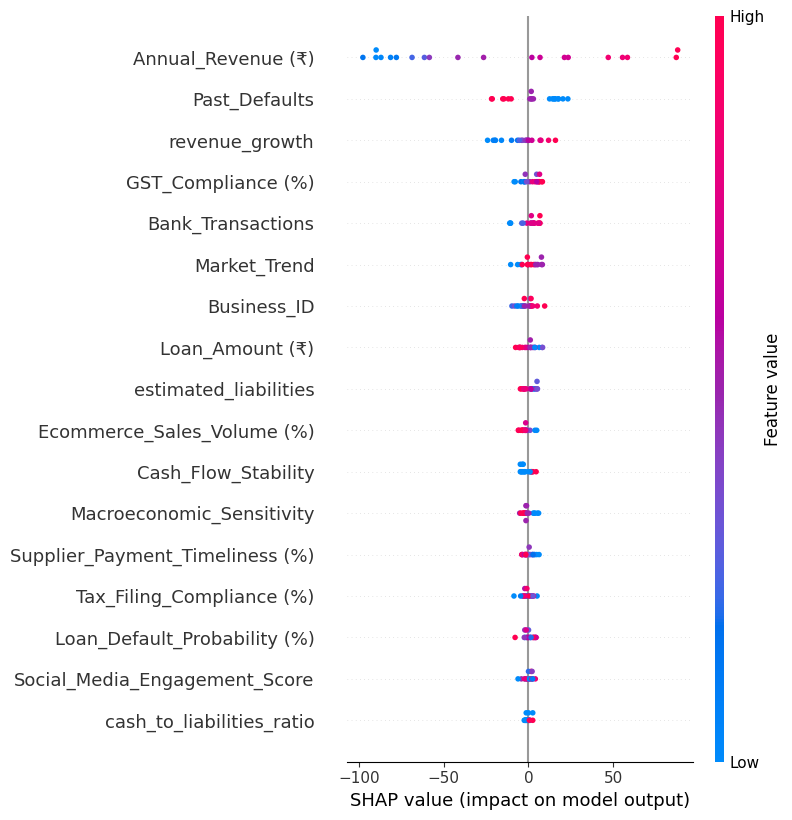

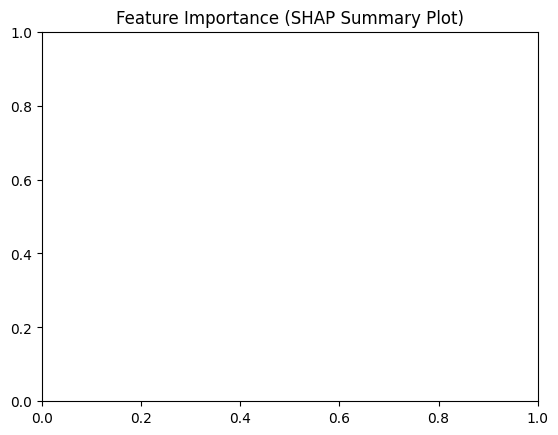

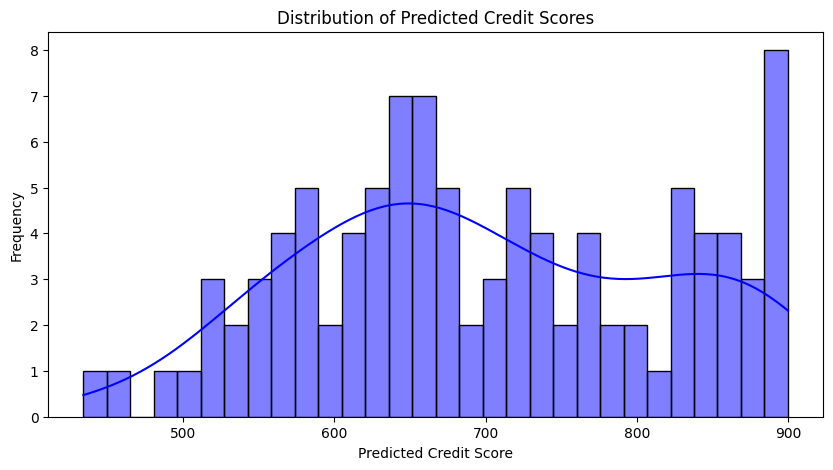

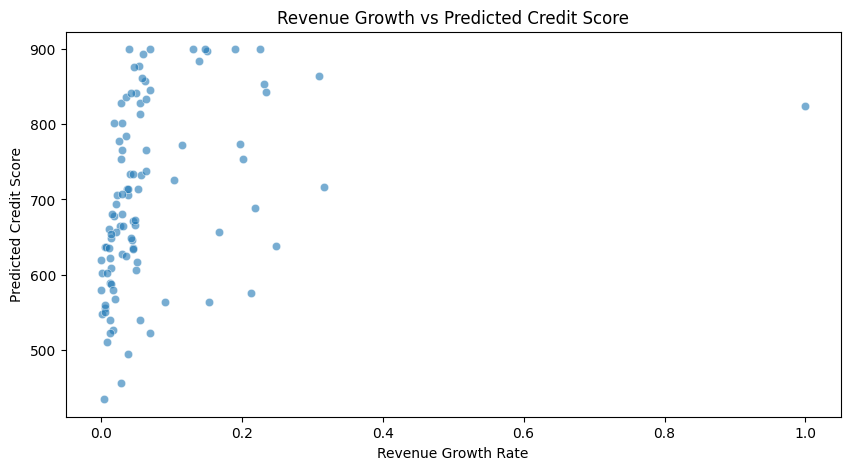

<ipython-input-7-257f89c47237>:80: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x="SHAP Value", y="Feature", data=shap_df, palette="viridis")


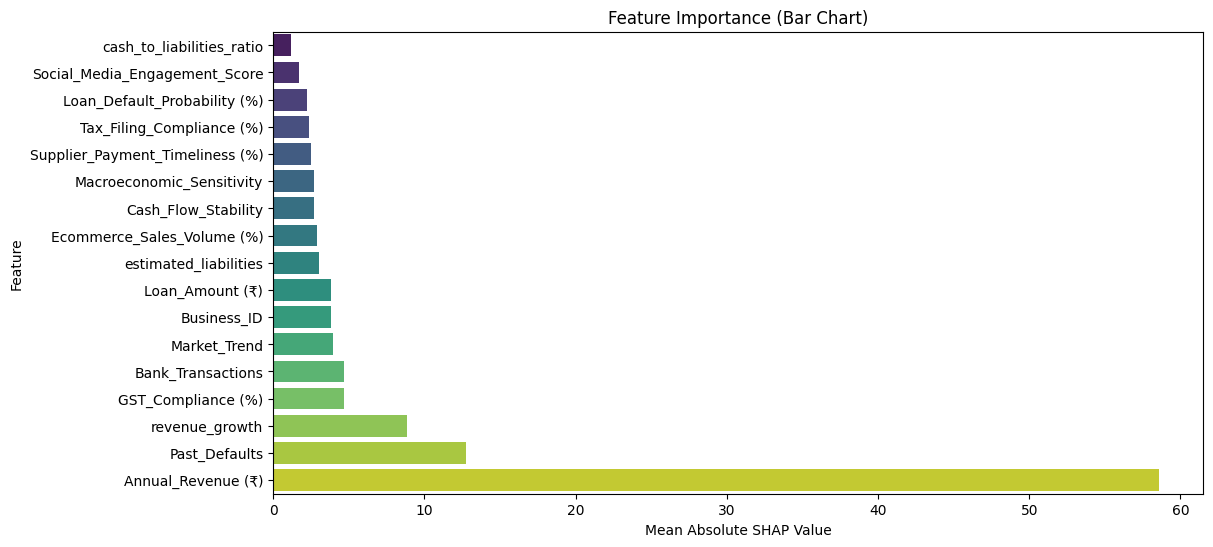

   cash_to_liabilities_ratio  revenue_growth  predicted_credit_score
0                   0.077355        0.038920              705.765808
1                   0.073372        0.055971              828.000000
2                   0.000000        0.012095              660.000001
3                   0.000000        0.046221              635.999999
4                   0.138901        0.056771              732.704327


In [ ]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler, LabelEncoder
from catboost import CatBoostRegressor
from sklearn.metrics import mean_absolute_error, r2_score
import shap

# Load dataset
data_path = "/content/enhanced_credit_data.csv"
df = pd.read_csv(data_path)

# Handle missing values
df.fillna(df.median(numeric_only=True), inplace=True)
df.fillna(df.mode().iloc[0], inplace=True)

# Encode categorical features
categorical_cols = df.select_dtypes(exclude=[np.number]).columns.tolist()
for col in categorical_cols:
    le = LabelEncoder()
    df[col] = le.fit_transform(df[col])

# Feature Engineering
df['estimated_liabilities'] = df['Loan_Amount (₹)'] * 1.5  # Estimated Liabilities
df['cash_to_liabilities_ratio'] = df['Cash_Flow_Stability'] / (df['estimated_liabilities'] + 1e-5)
df['revenue_growth'] = df['Annual_Revenue (₹)'].pct_change().fillna(0)

# Selecting Features
target = "Credit_Score"
features = [col for col in df.columns if col not in [target, 'risk_category']]

# Scaling
scaler = MinMaxScaler()
df[features] = scaler.fit_transform(df[features])

# Splitting dataset
X = df[features]
y = df[target]
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Model Training
catboost_model = CatBoostRegressor(iterations=1000, learning_rate=0.05, depth=8, loss_function='MAE', eval_metric='R2', verbose=200)
catboost_model.fit(X_train, y_train, eval_set=(X_test, y_test), early_stopping_rounds=100)

# Predictions
df['predicted_credit_score'] = catboost_model.predict(X)  # Store Predictions in DataFrame

# 1️⃣ *Feature Importance using SHAP*
explainer = shap.TreeExplainer(catboost_model)
shap_values = explainer.shap_values(X_test)

plt.figure(figsize=(10, 6))
shap.summary_plot(shap_values, X_test)
plt.title("Feature Importance (SHAP Summary Plot)")
plt.show()

# 2️⃣ *Distribution of Predicted Credit Scores*
plt.figure(figsize=(10, 5))
sns.histplot(df['predicted_credit_score'], bins=30, kde=True, color='blue')
plt.title("Distribution of Predicted Credit Scores")
plt.xlabel("Predicted Credit Score")
plt.ylabel("Frequency")
plt.show()

# 3️⃣ *Relationship between Revenue Growth & Predicted Score*
plt.figure(figsize=(10, 5))
sns.scatterplot(x=df['revenue_growth'], y=df['predicted_credit_score'], alpha=0.6)
plt.title("Revenue Growth vs Predicted Credit Score")
plt.xlabel("Revenue Growth Rate")
plt.ylabel("Predicted Credit Score")
plt.show()
# *Bar Chart: Feature Importance (SHAP Mean)*
shap_importance = np.abs(shap_values).mean(axis=0)  # Mean absolute SHAP values
shap_df = pd.DataFrame({'Feature': X_test.columns, 'SHAP Value': shap_importance})
shap_df = shap_df.sort_values(by="SHAP Value", ascending=True)

plt.figure(figsize=(12, 6))
sns.barplot(x="SHAP Value", y="Feature", data=shap_df, palette="viridis")
plt.title("Feature Importance (Bar Chart)")
plt.xlabel("Mean Absolute SHAP Value")
plt.ylabel("Feature")
plt.show()
# Print First 5 Rows
print(df[['cash_to_liabilities_ratio', 'revenue_growth', 'predicted_credit_score']].head())